In [1]:
import os
import sys
from collections import Counter
from scipy.sparse import csr_matrix
import numpy as np

#import dataset vocab
f = open('imdb_dataset/imdb.vocab', 'r')

word2id = {}
words = []

id = 0
for line in f:
    line = line.rstrip('\n')
    words.append(line)
    word2id[line] = id
    id += 1
    
def getID(word):
    if not word in word2id:
        return -1;
    return word2id[word]

#store in sparse CSR matrix
print("Reading Train Data ...")
X_reviews = []
X_values = []
X_row_indices = []
X_col_indices = []
Y = []

pFiles = os.listdir("imdb_dataset/train/pos")
nFiles = os.listdir("imdb_dataset/train/neg")

#Read positive files
for i in range(len(pFiles)):
    f = pFiles[i]
    lines = ""
    for line in open("imdb_dataset/train/pos/%s" % f, encoding="utf8"):
        lines += line
        wordCounts = Counter([getID(w.lower()) for w in line.split(" ")])
        for (wordId, count) in wordCounts.items():
            if wordId >= 0:
                X_row_indices.append(i)
                X_col_indices.append(wordId)
                X_values.append(count)
    Y.append(+1.0)
    X_reviews.append(lines)
    
#Read negative files
for i in range(len(nFiles)):
    f = nFiles[i]
    lines = ""
    for line in open("imdb_dataset/train/neg/%s" % f, encoding="utf8"):
        lines += line
        wordCounts = Counter([getID(w.lower()) for w in line.split(" ")])
        for (wordId, count) in wordCounts.items():
            if wordId >= 0:
                X_row_indices.append(len(pFiles)+i)
                X_col_indices.append(wordId)
                X_values.append(count)
    Y.append(-1.0)
    X_reviews.append(lines)
    
#Create a sparse matrix in csr format
X = csr_matrix((X_values, (X_row_indices, X_col_indices)), shape=(max(X_row_indices)+1, len(words)))        
Y = np.asarray(Y)

#Randomly shuffle
index = np.arange(X.shape[0])
np.random.shuffle(index)
X_train = X[index,:]
Y_train = Y[index]

print("OK")
#store in sparse CSR matrix
print("Reading Test Data ...")
X_reviews = []
X_values = []
X_row_indices = []
X_col_indices = []
Y = []
    
pFiles = os.listdir("imdb_dataset/test/pos")
nFiles = os.listdir("imdb_dataset/test/neg")

#Read positive files
for i in range(len(pFiles)):
    f = pFiles[i]
    lines = ""
    for line in open("imdb_dataset/test/pos/%s" % f, encoding="utf8"):
        lines += line
        wordCounts = Counter([getID(w.lower()) for w in line.split(" ")])
        for (wordId, count) in wordCounts.items():
            if wordId >= 0:
                X_row_indices.append(i)
                X_col_indices.append(wordId)
                X_values.append(count)
    Y.append(+1.0)
    X_reviews.append(lines)
    
#Read negative files
for i in range(len(nFiles)):
    f = nFiles[i]
    lines = ""
    for line in open("imdb_dataset/test/neg/%s" % f, encoding="utf8"):
        lines += line
        wordCounts = Counter([getID(w.lower()) for w in line.split(" ")])
        for (wordId, count) in wordCounts.items():
            if wordId >= 0:
                X_row_indices.append(len(pFiles)+i)
                X_col_indices.append(wordId)
                X_values.append(count)
    Y.append(-1.0)
    X_reviews.append(lines)
    
#Create a sparse matrix in csr format
X_test = csr_matrix((X_values, (X_row_indices, X_col_indices)), shape=(max(X_row_indices)+1, len(words)))        
Y_test = np.asarray(Y)

#Randomly shuffle
index = np.arange(X_test.shape[0])
np.random.shuffle(index)
X_test = X_test[index,:]
Y_test = Y_test[index]
print("OK")

Reading Train Data ...
OK
Reading Test Data ...
OK


In [2]:
import numpy as np
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

class Eval:
    def __init__(self, pred, gold):
        self.pred = pred
        self.gold = gold
        
    def Accuracy(self):
        return np.sum(np.equal(self.pred, self.gold)) / float(len(self.gold))
    
    def Recall(self):
        return recall_score(self.gold,self.pred)
    
    def Precision(self):
         return precision_score(self.gold,self.pred)
     
    def PvRcurve(self):
        average_precision = average_precision_score(self.gold, self.pred)
        precision, recall, _ = precision_recall_curve(self.gold, self.pred)

        plt.step(recall, precision, color='b', alpha=0.2,where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        plt.show()

In [3]:
from math import log, exp

class NaiveBayes:
    def __init__(self, dataX, dataY, ALPHA=1.0):
        self.ALPHA = ALPHA
        self.dataX = dataX
        self.dataY = dataY
        self.vocab_len = 1
        self.count_positive = 1
        self.count_negative = 1
        self.num_positive_reviews = 1
        self.num_negative_reviews = 1
        self.total_positive_words = 1
        self.total_negative_words = 1
        self.P_positive = 1
        self.P_negative = 1
        self.deno_pos = 1
        self.deno_neg =1
        self.pos_words=[]
        self.neg_words=[]
        self.train(dataX,dataY)

    # Train model - X are instances, Y are labels (+1 or -1)
    # X and Y are sparse matrices
    def train(self, X, Y):
        #TODO: Estimate Naive Bayes model parameters
        #calculate frequency parameters to be used in PredictLabel to calculate probabilities
        positive_indices = np.argwhere(Y == 1.0).flatten()
        negative_indices = np.argwhere(Y == -1.0).flatten()
        
        self.num_positive_reviews = sum([1 if i==1 else 0 for i in Y])
        self.num_negative_reviews = sum([1 if i==-1 else 0 for i in Y])
        self.count_positive = np.zeros(X.shape[1])
        self.count_negative = np.zeros(X.shape[1])
        self.total_positive_words = np.sum(X[positive_indices,:])
        self.total_negative_words = np.sum(X[negative_indices,:])
        
        #For smoothing
        self.deno_pos = self.total_positive_words + self.ALPHA*X.shape[1]
        self.deno_neg = self.total_negative_words + self.ALPHA*X.shape[1]
        
        rows,columns = X.nonzero()
        for i,j in zip(rows,columns):
            if self.dataY[i]==1:
                    self.count_positive[j]+=X[i,j]
            else:
                    self.count_negative[j]+=X[i,j]
        self.count_positive = (self.count_positive + self.ALPHA)
        self.count_negative = (self.count_negative + self.ALPHA)        
        #above 2 arrays give total frequencies for each word in each class
        return

    # Predict labels for instances X
    # Return: Sparse matrix Y with predicted labels (+1 or -1)
    def PredictLabel(self, X, threshold=0.5):
        #Calculate P(W|C) and P(C) to get P(C|W) by doing a logsum
        self.P_positive = log(self.num_positive_reviews)-(log(self.num_positive_reviews)+log(self.num_negative_reviews))
        self.P_negative = log(self.num_negative_reviews)-(log(self.num_positive_reviews)+log(self.num_negative_reviews))
        pred_labels = []
        w=X.shape[1]
        sh = X.shape[0]
        for i in range(sh):
            #laplath smoothing
            z = X[i].nonzero()
            positive_sum = self.P_positive
            negative_sum = self.P_negative
            for j in range(len(z[0])):
                # Look at each feature
                row_index = i
                col_index = z[1][j]
                occurrence = X[row_index, col_index]
                P_pos = log(self.count_positive[col_index]) - log(self.deno_pos)
                positive_sum = positive_sum + occurrence * P_pos
                P_neg = log(self.count_negative[col_index]) - log(self.deno_neg)
                negative_sum = negative_sum + occurrence * P_neg
                probValue = exp(positive_sum - self.LogSum(positive_sum, negative_sum))
            if probValue > threshold:            # Predict positive
                pred_labels.append(1.0)
            else:               # Predict negative
                pred_labels.append(-1.0)  
                
        return pred_labels


    def LogSum(self, logx, logy):   
        # TO DO: Return log(x+y), avoiding numerical underflow/overflow.
        m = max(logx, logy)   
        #print(m)
        return m + log(exp(logx - m) + exp(logy - m))

    # Predict the probability of each indexed review in sparse matrix text
    # of being positive
    # Prints results
    def PredictProb(self, testX, testY, indexes):
         
        for i in indexes:
            predicted_label = 0
            z = testX[i].nonzero()
            positive_sum = self.P_positive
            negative_sum = self.P_negative

            for j in range(len(z[0])):
                row_index = i
                col_index = z[1][j]
                occurrence = testX[row_index, col_index]
                P_pos = log(self.count_positive[col_index])
                positive_sum = positive_sum + occurrence * P_pos
                P_neg = log(self.count_negative[col_index])
                negative_sum = negative_sum + occurrence * P_neg
                

            predicted_prob_positive = exp(positive_sum - self.LogSum(positive_sum, negative_sum))
            predicted_prob_negative = exp(negative_sum - self.LogSum(positive_sum, negative_sum))

            if positive_sum > negative_sum:
                predicted_label=1.0
            else:
                predicted_label=-1.0

            print (testY[i], testX[i],predicted_label)

    # Evaluate performance on test data 
    #Gives Accuracy, Precision and Recall for different values of a threshold
    def Eval(self):
        Y_pred = self.PredictLabel(X_test)
        ev = Eval(Y_pred, Y_test)
        print("For Positive Class:")
        print("Test Accuracy: ",ev.Accuracy())
        print("Test Recall: ",ev.Recall())
        print("Test Precision: ",ev.Precision())
        print("\n")
        print("For Negative Class:")
        ev_neg = Eval([1 if i == -1 else -1 for i in Y_pred], [1 if i == -1 else -1 for i in Y_test])
        print("Test Accuracy: ",ev_neg.Accuracy())
        print("Test Recall: ",ev_neg.Recall())
        print("Test Precision: ",ev_neg.Precision())
        probality_threshold=[0.2,0.4,0.6,0.8]
        Precision=[]
        Recall=[]
        Precision.append(ev.Precision())
        Recall.append(ev.Recall())
        length=len(probality_threshold)
        for i in range(0,length):
            Y_pred = self.PredictLabel(X_test,probality_threshold[i])
            ev = Eval(Y_pred, Y_test)
            Precision.append(ev.Precision())
            Recall.append(ev.Recall())
        plt.plot(Precision,Recall)
        plt.ylabel('Recall')
        plt.xlabel('Precision')
        plt.title('2-class Precision-Recall curve')
        plt.show()
        #above statements show a Precision vs Recall graph

    #TO-DO: give top 20 positive and negative words based on their log odds
    #words with the max difference value would be part of this list
    def Features(self):
        pos_diff=np.zeros(self.data.X.shape[1])
        neg_diff=np.zeros(self.data.X.shape[1])
        for j in range(len(self.count_positive)):
                P_pos = log(self.count_positive[j]) - log(self.deno_pos)
                P_neg = log(self.count_negative[j]) - log(self.deno_neg)
                pos_diff[j]=(P_pos-P_neg)
                #neg_diff[j]=(P_neg-P_pos)*(self.count_negative[j]-self.count_positive[j])
        print("Top 20 Positive words with their weights:")        
        pos_index=pos_diff.argsort()[-20:][::-1]
        for j in pos_index:
            print("j:",self.data.vocab.GetWord(j)," ",pos_diff[j])
        
        print("Top 20 Negative words with their weights:")
        neg_index=pos_diff.argsort()[:20]
        for j in neg_index:
            print("j:",self.data.vocab.GetWord(j)," ",pos_diff[j])

Computing Parameters
Evaluating
For Positive Class:
Test Accuracy:  0.80132
Test Recall:  0.7416
Test Precision:  0.8421913327882257


For Negative Class:
Test Accuracy:  0.80132
Test Recall:  0.86104
Test Precision:  0.769170299435432


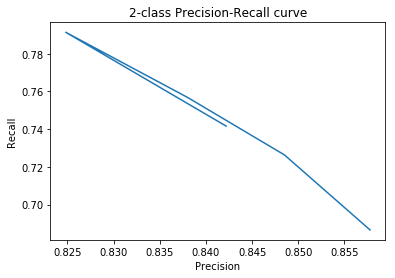

In [4]:
print("Computing Parameters")
nb = NaiveBayes(X_train, Y_train)
print("Evaluating")    
nb.Eval()